In [27]:
import os
import numpy as np
from scipy.ndimage import median_filter, gaussian_filter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from astropy.io import fits

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import minmax_scale

sns.set(context="talk", style="ticks", palette="Set2")

from MaStarChecks.stellarLibraries.catalogues import build_miles_catalogue, build_mastar_catalogue
from MaStarChecks.stellarLibraries.spectra import load_miles_seds, load_mastar_seds

In [28]:
miles_reference, miles_catalogue, miles_parameter = build_miles_catalogue()
mastar_reference, mastar_catalogue, mastar_parameter = build_mastar_catalogue()

miles_seds = load_miles_seds(ext_corrected=False)
mastar_seds = load_mastar_seds(reference=mastar_reference)

In [29]:
wl_miles = pd.DataFrame()
fl_miles = pd.DataFrame()
for sedname in tqdm(miles_seds.keys(), desc="processing MILES SEDs", unit="SED"):
    wl_miles[sedname], fl_miles[sedname] = miles_seds[sedname]

processing MILES SEDs: 100%|██████████| 985/985 [00:01<00:00, 963.29SED/s] 


In [30]:
wl_mastar = pd.DataFrame()
fl_mastar = pd.DataFrame()
for sedname in tqdm(mastar_seds.keys(), desc="processing MaStar SEDs", unit="SED"):
    seds = mastar_seds[sedname]
    for sed in seds:
        if sedname in wl_mastar:
            wl_mastar[sedname]
        else:
            wl_mastar[sedname], fl_mastar[sedname] = sed[0], sed[1]

processing MaStar SEDs: 100%|██████████| 3326/3326 [00:07<00:00, 451.44SED/s]


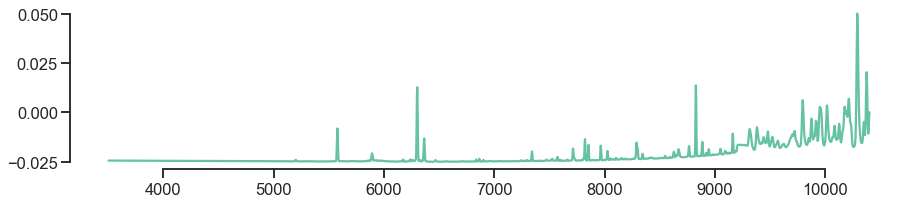

In [32]:
wl_sky, fl_sky = np.loadtxt("../_data/sky-sed/sky-opt-sed.txt", unpack=True)

wl_sky = 10*wl_sky
mask = (wl_sky>=3500)&(wl_sky<=10400)
wl_sky = wl_sky[mask]
fl_sky = fl_sky[mask]

fl_sky = gaussian_filter(fl_sky, sigma=1)
fl_sky = minmax_scale(fl_sky, (-0.025,+0.05))

plt.figure(figsize=(15,3))
plt.plot(wl_sky, fl_sky, "-")
sns.despine(trim=True)

In [33]:
N_COMP = 3

pca_miles = PCA(n_components=N_COMP, random_state=432)

X_miles = StandardScaler().fit_transform(fl_miles.transpose().values)
X_miles_pca = pca_miles.fit_transform(X_miles)

pca_mastar = PCA(n_components=N_COMP, random_state=432)

X_mastar = StandardScaler().fit_transform(fl_mastar.transpose().values)
X_mastar_pca = pca_mastar.fit_transform(X_mastar)

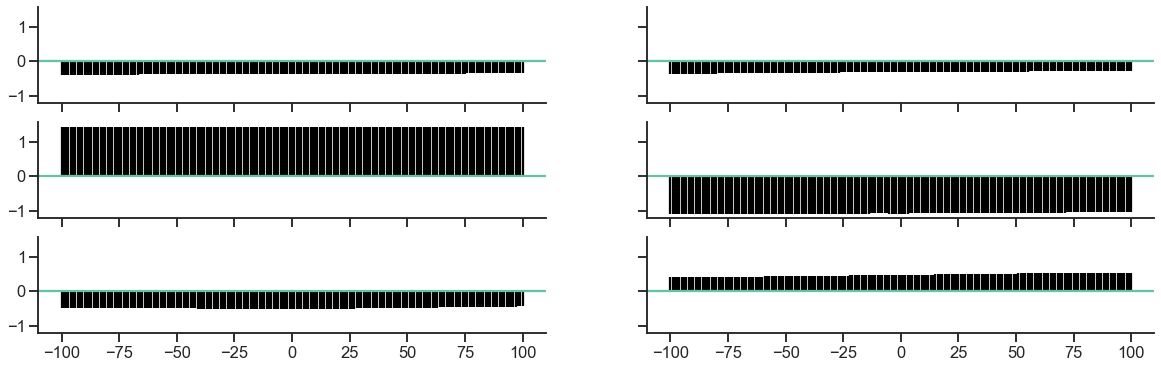

In [34]:
fig, axs = plt.subplots(pca_miles.n_components, 2, sharex=True, sharey=True, figsize=(20, 2*pca_miles.n_components))

w_miles = wl_miles.transpose().drop_duplicates().squeeze().values
w_mastar = wl_mastar.transpose().drop_duplicates().squeeze().values
for i in range(axs.shape[0]):
    w_mastar = w_mastar / (1.0 + 2.735182E-4 + 131.4182 / w_mastar**2 + 2.76249E8 / w_mastar**4)
    
    fl_sky_miles = np.interp(w_miles, wl_sky, fl_sky)
    fl_sky_mastar = np.interp(w_mastar, wl_sky, fl_sky)
    
    axs[i, 0].xcorr(fl_sky_miles, gaussian_filter(pca_miles.components_[i], sigma=1), maxlags=100, normed=False, usevlines=True)
    axs[i, 1].xcorr(fl_sky_mastar, gaussian_filter(pca_mastar.components_[i], sigma=1), maxlags=100, normed=False, usevlines=True)
#     if axs[i, 0].is_first_row():
#         axs[i, 0].set_title("MILES PCA")
#         axs[i, 1].set_title("MaStar PCA")
#     axs[i, 0].set_ylabel(f"PC #{i+1}")
#     if axs[i, 0].is_last_row():
#         axs[i, 0].set_xlabel(r"Wavelength ($\AA$)")
#         axs[i, 1].set_xlabel(r"Wavelength ($\AA$)")
    
#     axs[i, 0].text(3500, 0.05, r"$\sigma^2_{\rm explained}=$%.1f%%"%(pca_miles.explained_variance_ratio_[i]*100), ha="left", va="center")
#     axs[i, 1].text(3500, 0.05, r"$\sigma^2_{\rm explained}=$%.1f%%"%(pca_mastar.explained_variance_ratio_[i]*100), ha="left", va="center")


# plt.ylim(-0.05, +0.05)
sns.despine(trim=False)
# fig.tight_layout()

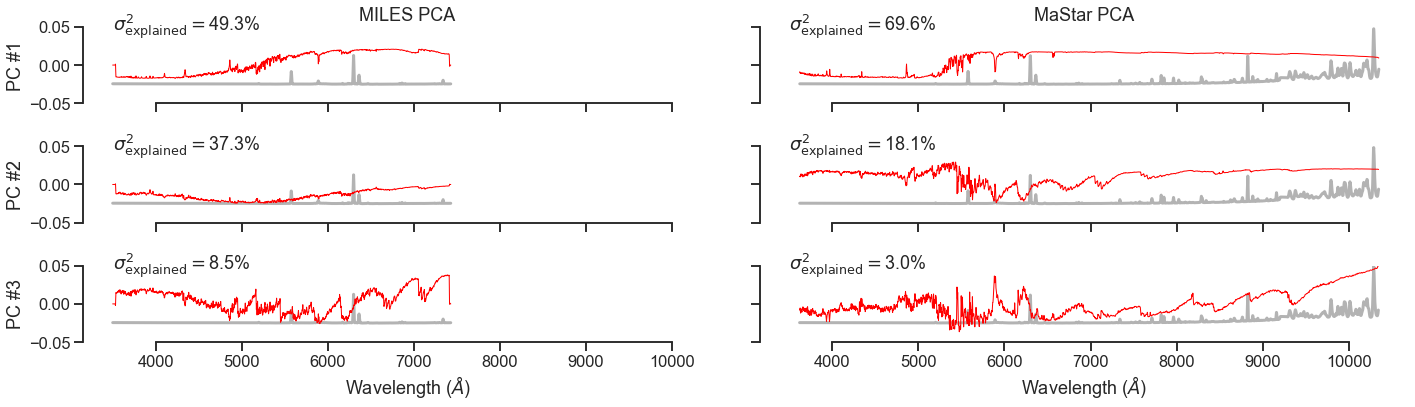

In [35]:
fig, axs = plt.subplots(pca_miles.n_components, 2, sharex=True, sharey=True, figsize=(20, 2*pca_miles.n_components))

w_miles = wl_miles.transpose().drop_duplicates().squeeze().values
w_mastar = wl_mastar.transpose().drop_duplicates().squeeze().values
for i in range(axs.shape[0]):
    w_mastar = w_mastar / (1.0 + 2.735182E-4 + 131.4182 / w_mastar**2 + 2.76249E8 / w_mastar**4)
    
    fl_sky_miles = np.interp(w_miles, wl_sky, fl_sky)
    fl_sky_mastar = np.interp(w_mastar, wl_sky, fl_sky)
    
    axs[i, 0].plot(w_miles, fl_sky_miles, "-", lw=3, color="0.7")
    axs[i, 1].plot(w_mastar, fl_sky_mastar, "-", lw=3, color="0.7")
    axs[i, 0].plot(w_miles, gaussian_filter(pca_miles.components_[i], sigma=1), "-", color="r", lw=1)
    axs[i, 1].plot(w_mastar, gaussian_filter(pca_mastar.components_[i], sigma=1), "-", color="r", lw=1)
    
    if axs[i, 0].is_first_row():
        axs[i, 0].set_title("MILES PCA")
        axs[i, 1].set_title("MaStar PCA")
    axs[i, 0].set_ylabel(f"PC #{i+1}")
    if axs[i, 0].is_last_row():
        axs[i, 0].set_xlabel(r"Wavelength ($\AA$)")
        axs[i, 1].set_xlabel(r"Wavelength ($\AA$)")
    
    axs[i, 0].text(3500, 0.05, r"$\sigma^2_{\rm explained}=$%.1f%%"%(pca_miles.explained_variance_ratio_[i]*100), ha="left", va="center")
    axs[i, 1].text(3500, 0.05, r"$\sigma^2_{\rm explained}=$%.1f%%"%(pca_mastar.explained_variance_ratio_[i]*100), ha="left", va="center")


plt.ylim(-0.05, +0.05)
sns.despine(trim=True)
fig.tight_layout()